In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io

import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, rgb2hex
plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

import scipy.ndimage as ndimg

from cellpose import utils
from skimage.io import imread
import scipy
from skimage.morphology import binary_erosion, medial_axis, disk, medial_axis,remove_small_holes,remove_small_objects
from scipy.ndimage.morphology import binary_dilation, binary_opening
from skimage.measure import label, regionprops

# import skfmm
import cv2
from skimage import measure

import fastremap #important for relabeling! Could move just to color function perhaps, but idk of other parts of cellpose require sequential lebel matrices; probably worth it
import edt

from cellpose import models, io, dynamics, plot, transforms, metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


mask area 256


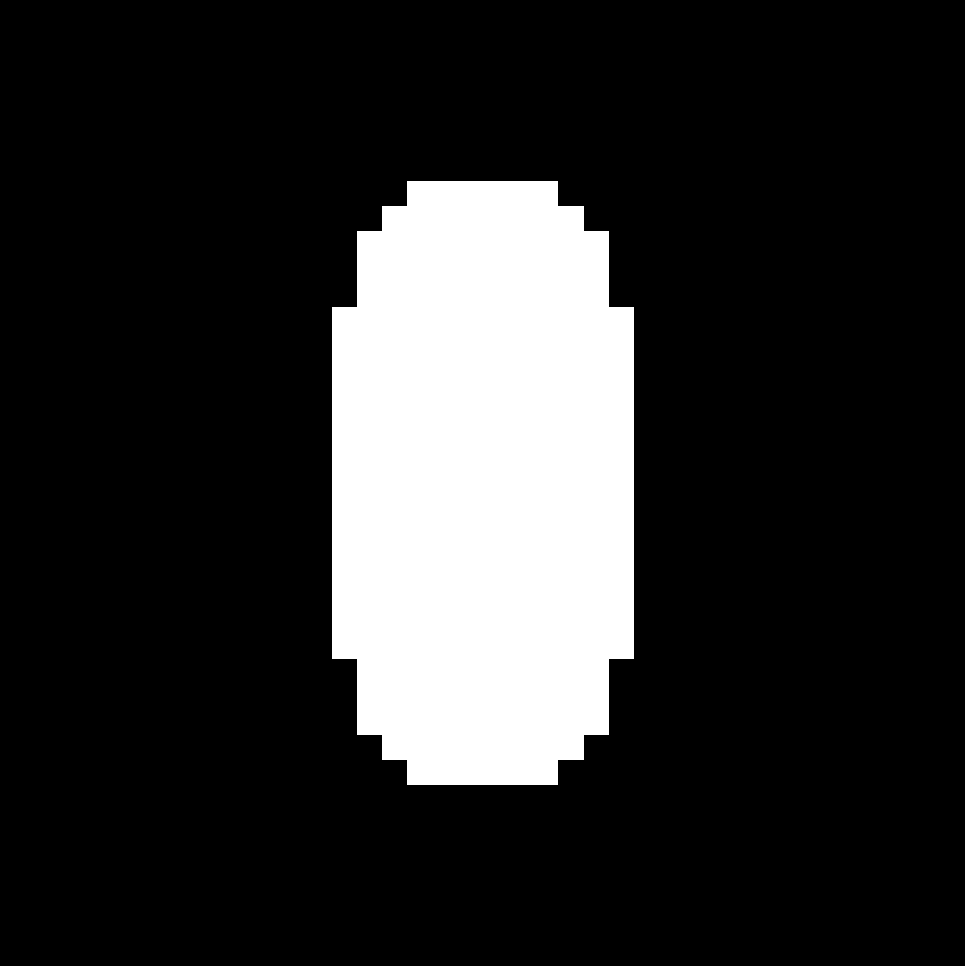

1.0 256 1.00
0.8285714285714286 256 0.83
0.6842105263157895 256 0.68
0.5609756097560976 256 0.56
0.45454545454545453 256 0.45
0.3617021276595745 256 0.36
0.28 256 0.28
0.2132701421800948 256 0.21
0.15315315315315314 256 0.15
0.10344827586206896 256 0.10
0.05785123966942149 256 0.06
0.028112449799196786 256 0.03
0.0 256 0.00


In [4]:
from scipy.ndimage import uniform_filter
import numpy.ma as ma
import cv2
golden = (1 + 5 ** 0.5) / 2
sz = 1


l = 24
n = 1
a = 3
b = .5
r = l/2

L = np.ceil(l*b).astype(int)+1
pad = (L/2).astype(int)

x, y = np.indices((l, l))
center = (l/2-.5, l/2-.5)
circle = np.abs(x - center[0])**a + np.abs((y - center[1])/b)**a < r**a
mask = np.pad(circle,pad).astype(int)
print('mask area',np.sum(mask))

Ly, Lx = mask.shape
Y,X = np.nonzero(mask)
plt.imshow(mask)
plt.axis('off')
plt.show()

basedir = '/home/kcutler/DataDrive/omnipose_paper/Figure S2'
io.check_dir(basedir)

ious = np.zeros(L)
pics = [[]]*(L)
for dx in range(L):
    mask2 = np.zeros_like(mask).astype(int)
    mask2[Y,X-dx] = 1.
    iou =  metrics._intersection_over_union(mask,mask2)[-1,-1]
    ious[dx] = iou
    print(iou,np.sum(mask),'%.2f'%iou)
    bd = edt.edt(mask) == 1
    bd2 = edt.edt(mask2) == 1
    p = np.stack([mask]*3,axis=-1)
    pic = plot.outline_view(p,bd2)*1.
    
    y,x = np.nonzero(1-pic[:,:,1]>0)
#     pic = pic[:,max(x.min()-5,0):min(x.max()+1+5,Lx)]
    pics[dx] = pic
#     plt.imshow()
#     plt.axis('off')
#     plt.show()
    io.imsave(os.path.join(basedir,'iou_%.2f'%iou+'_cell_'+str(l)+'.png'),((pic)*255).astype(np.uint8))

[Text(18.0, 0, '1.00'),
 Text(55.5, 0, '0.83'),
 Text(93.0, 0, '0.68'),
 Text(130.5, 0, '0.56'),
 Text(168.0, 0, '0.45'),
 Text(205.5, 0, '0.36'),
 Text(243.0, 0, '0.28'),
 Text(280.5, 0, '0.21'),
 Text(318.0, 0, '0.15'),
 Text(355.5, 0, '0.10'),
 Text(393.0, 0, '0.06'),
 Text(430.5, 0, '0.03'),
 Text(468.0, 0, '0.00')]

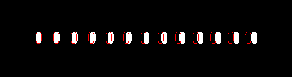

In [5]:
fp = np.hstack(pics)
ly,lx = fp.shape[:2]
fig = plt.figure(figsize=(sz, 2*sz*ly/lx)) 
ax = plt.axes()
plt.imshow(fp)
plt.axis('off')
# plt.axis('off')
w = pic.shape[1]
ax.set_xticks(np.linspace(w/2,L*w,L))
ax.set_xticklabels(['%.2f'%i for i in ious])
# pics[0][0]
# io.imsave(os.path.join(basedir,'iou_%.2f'%iou+'_stack_cell_'+str(l)+'.png'),((fp)*255).astype(np.uint8))

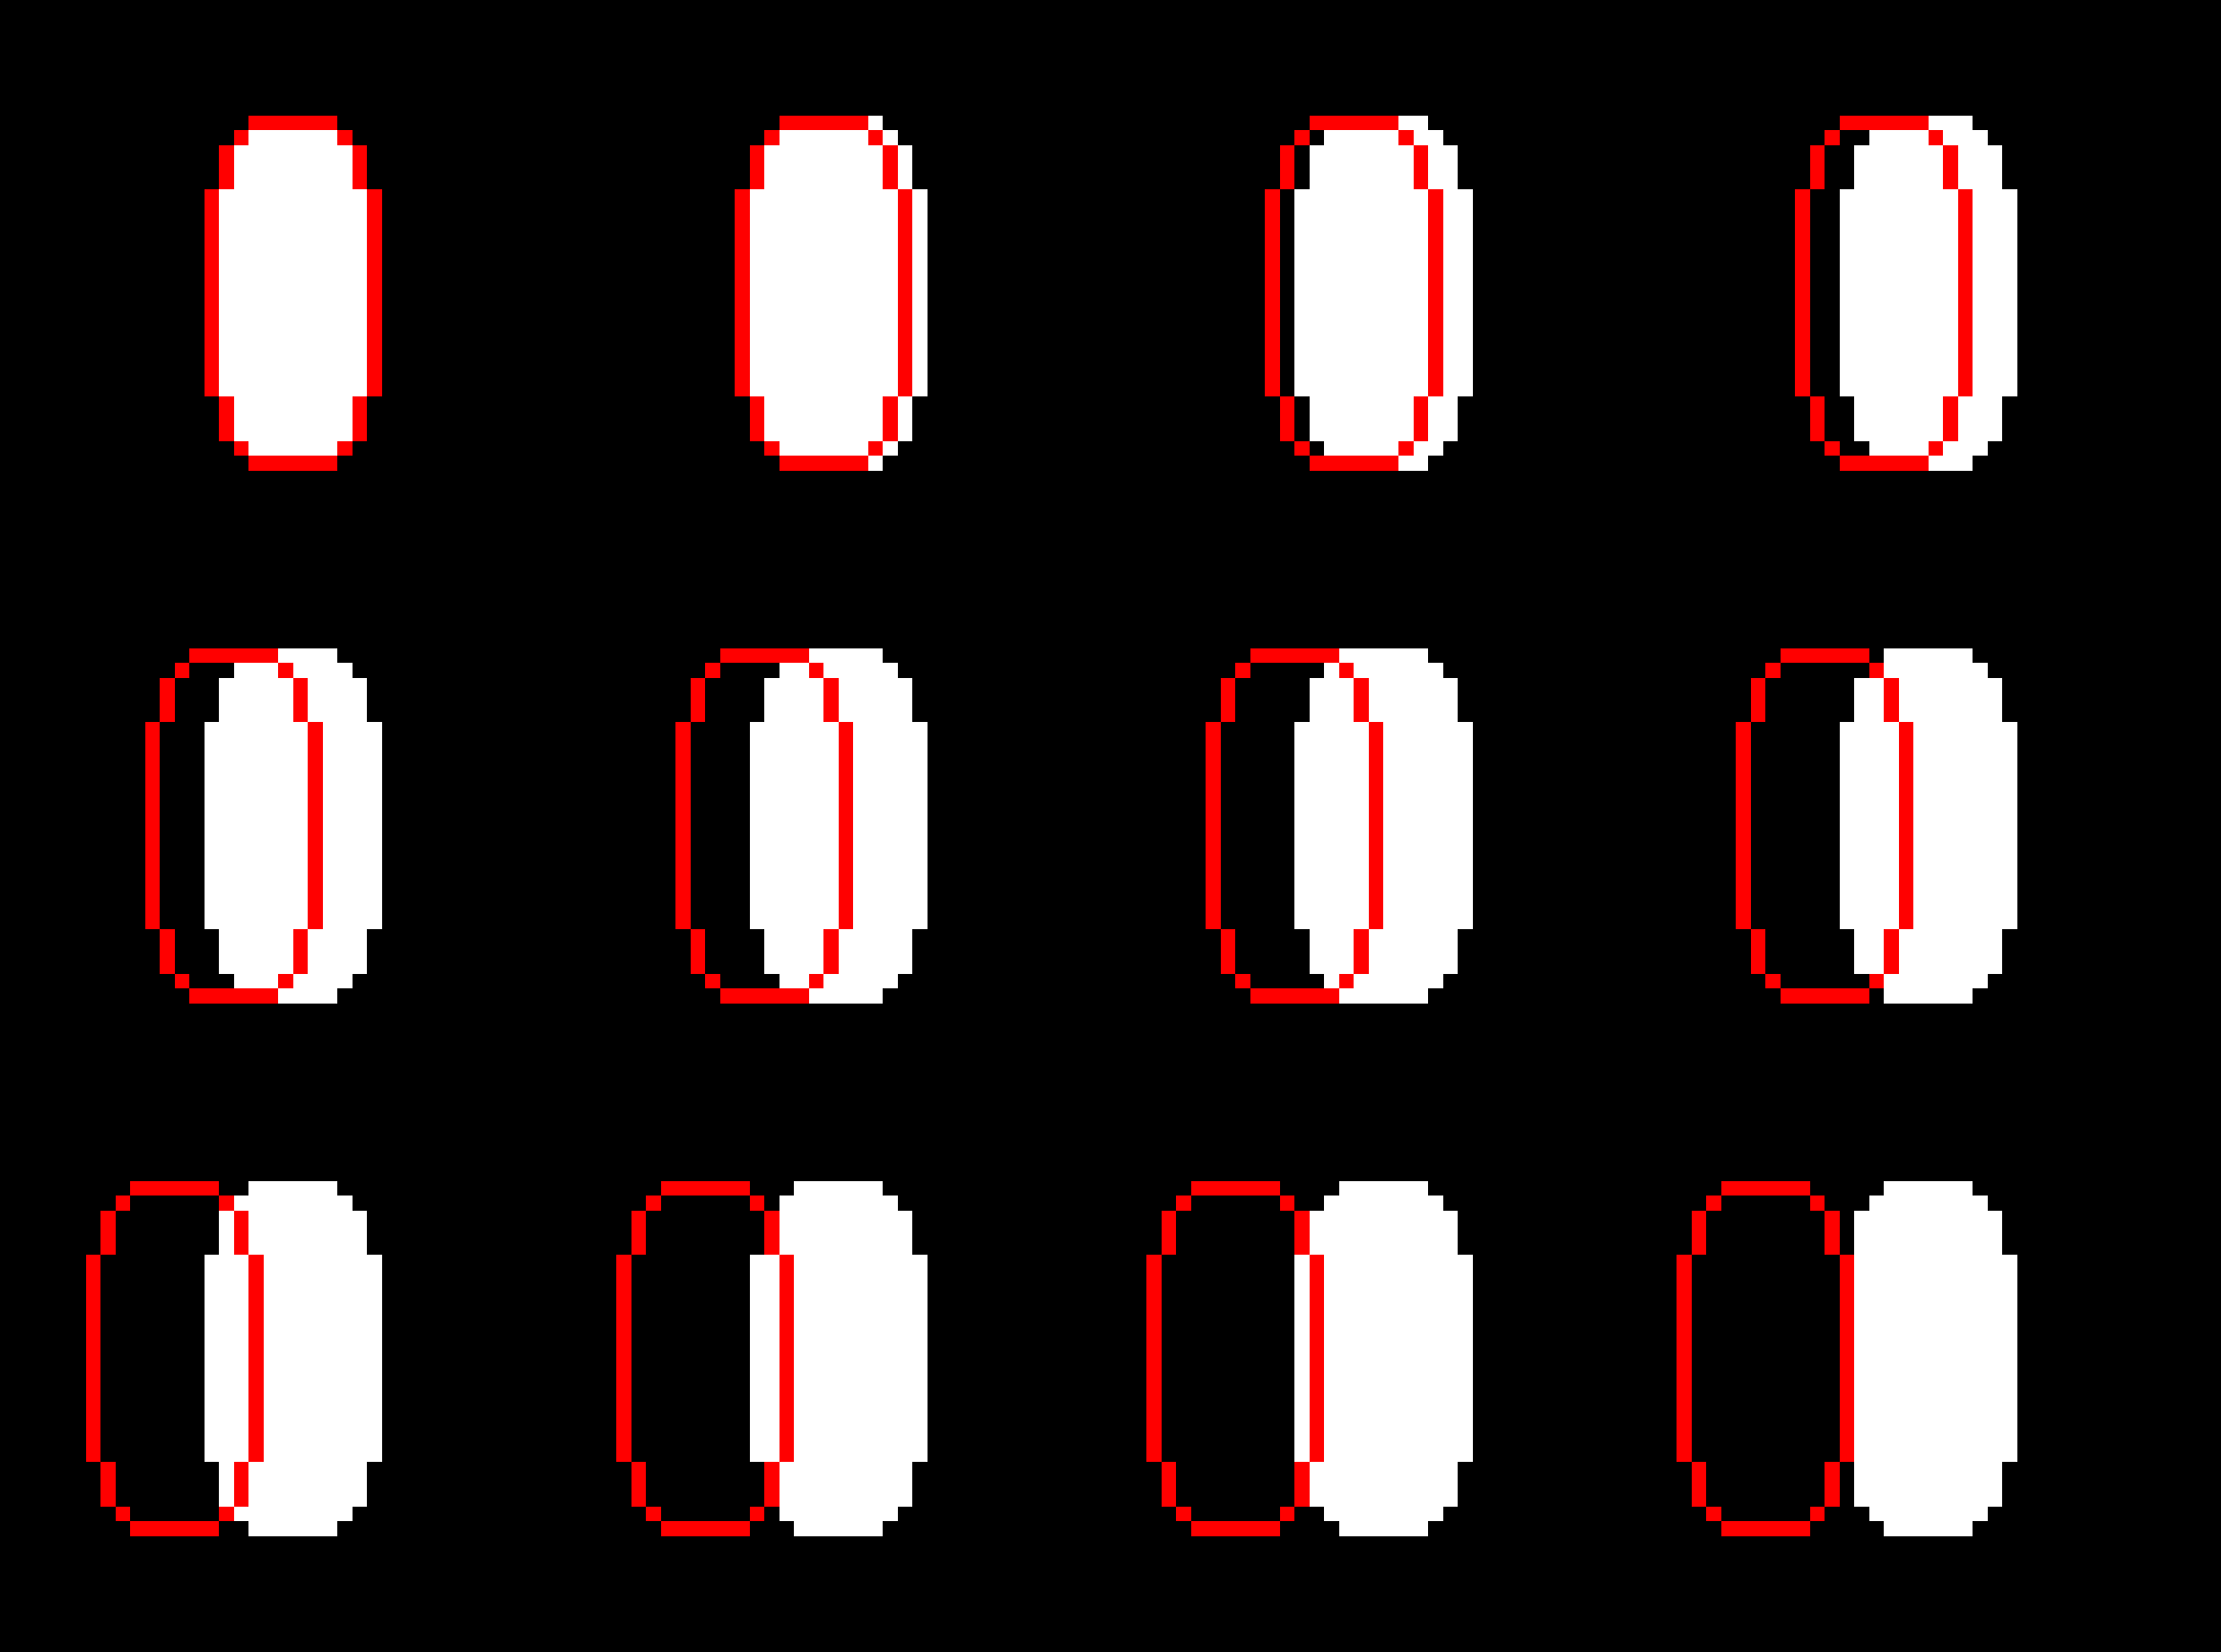

In [6]:
sz = 9
labelsize = 9
fig,axs = plt.subplots(3,4,figsize=(sz, sz*3/4)) 
axs = axs.flatten()
for l in range(min(12,L)):
    # for l in range(L):
    ax = axs[l]
    ax.imshow(pics[l],interpolation='nearest')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('%.2f'%ious[l],size=labelsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
plt.subplots_adjust(bottom=0,left=0,wspace=0,hspace=0)
fig.savefig(os.path.join(basedir,'cells.eps'),bbox_inches='tight')


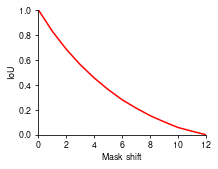

In [7]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'png')
mpl.rcParams['figure.dpi'] = 72
mpl.rcParams["ps.usedistiller"] = 'xpdf'
# rc('text.latex', preamble=r'\usepackage{cmbright}')


ly,lx = fp.shape[:2]
labelsize = 9

axcol = 'k'
background_color = np.array([1,1,1,0])
sz = 3
fig = plt.figure(figsize=(sz, sz*3/4)) 
ax = plt.axes()
plt.plot(ious,color='r')

ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.set_ylabel('IoU', fontsize = labelsize)
ax.set_xlabel('Mask shift', fontsize = labelsize)
ax.set_ylim(0,1)
ax.set_xlim(0,L-1)
ax.set_xticks(range(0,L,2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

fig.patch.set_facecolor(background_color)
plt.show()


fig.savefig(os.path.join(basedir,'IoU.eps'),bbox_inches='tight')

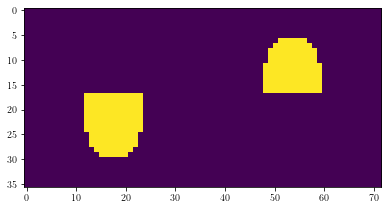

[[0.546875 0.453125]] 256 0.50


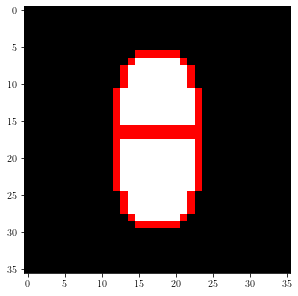

TypeError: only size-1 arrays can be converted to Python scalars

In [40]:
bd = edt.edt(mask) == 1
mask2 = np.zeros_like(mask).astype(int)
mask3 = np.zeros_like(mask).astype(int)
y0 = np.percentile(y,50).astype(int)
select1 = Y>=y0
select2 = Y<y0
mask2[Y[select1],X[select1]] = 1.
mask3[Y[select2],X[select2]] = 1.

plt.imshow(np.hstack((mask2,mask3)))
plt.show()

masks = mask2+2*mask3
iou =  metrics._intersection_over_union(mask,masks)[1:,1:]
print(iou,np.sum(mask),'%.2f'%np.mean(iou))
bd = edt.edt(mask) == 1
bd2 = edt.edt(masks) == 1
p = np.stack([mask]*3,axis=-1)
pic = plot.outline_view(p,bd2)*1.
plt.imshow(pic)
plt.show()

# skimage.io.imsave(os.path.join(basedir,'iou_%.2f'%iou+'_split.eps'),((pic)*255).astype(np.uint8),dpi=1200)
plt.imsave(os.path.join(basedir,'iou_%.2f'%iou+'_split.png'),((pic)*255).astype(np.uint8),dpi=1200,interpolation='nearest')


In [108]:
def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols

ly,lx,ch= pics[0].shape
pic = np.zeros((ly*3,lx*4,ch))
for j in range(3):
    for k in range(4):
        pic[j*ly:(j+1)*ly,k*lx:(k+1)*lx] = pics[sub2ind((3,4),j,k)]


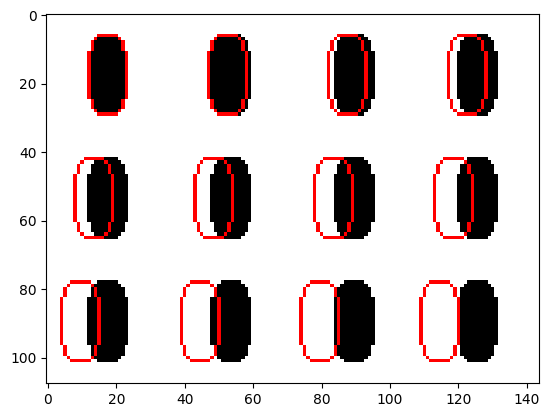

In [109]:
plt.imshow(pic)
io.imsave(os.path.join(basedir,'cell'+str(l)+'_grid.png'),((pic)*255).astype(np.uint8))